## Sentiment Analysis on Yelp Reviews
### The Yelp reviews dataset consist of reviews from Yelp
#### The Yelp reviews full star dataset is constructed by taking randomly 130,000 training samples and 10,000 testing samples for each review star from 1 to 5. There are 2 columns in them, corresponding to class index (1 to 5) and review text.

#### In this project NLP sentiment analysis on yelp reviews is done using various models such as Support Vector Machine (SVM), Random Forest Classifier, Logistic Regression, XGBoost model and Naive Bayes

#### EDA Augmentation is also applied for the same dataset and the performance metrics for before and after augmentation is compared 



### 1. Importing the relevent libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

### 2. Loading the train and test data

In [2]:
# Reading the train and test dataset
df_train=pd.read_csv('train.csv',header=None)
df_test=pd.read_csv('test.csv',header=None)
df_train.head()

,0,1
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


In [3]:
# Changing the names of the header for both the columns to Reviews and Ratings
df_train=df_train.rename(columns={0:'Ratings',1:'Reviews'})
df_test=df_test.rename(columns={0:'Ratings',1:'Reviews'})
df_train.head()

,Ratings,Reviews
0,5,dr. goldberg offers everything i look for in a...
1,2,"Unfortunately, the frustration of being Dr. Go..."
2,4,Been going to Dr. Goldberg for over 10 years. ...
3,4,Got a letter in the mail last week that said D...
4,1,I don't know what Dr. Goldberg was like before...


#### The ratings are from 1 to 5. For proper analysis we convert the rating from 1,2 as 0(negative reviews) and 3,4,5 as 1 (positive reviews)

In [4]:
#for train dataset
df_train_new=df_train.copy()
df_train_new['Ratings']=df_train['Ratings'].apply(lambda x: 1 if (x>2) else 0)
df_train_new=df_train_new.reset_index()
df_train_new=df_train_new[['Reviews','Ratings']]
df_train_new.head()

,Reviews,Ratings
0,dr. goldberg offers everything i look for in a...,1
1,"Unfortunately, the frustration of being Dr. Go...",0
2,Been going to Dr. Goldberg for over 10 years. ...,1
3,Got a letter in the mail last week that said D...,1
4,I don't know what Dr. Goldberg was like before...,0


In [5]:
df_train_new['Ratings'].value_counts()

1    390000
0    260000
Name: Ratings, dtype: int64

In [6]:
# for test dataset
df_test_new=df_test.copy()
df_test_new['Ratings']=df_test['Ratings'].apply(lambda x: 1 if (x>2) else 0)
df_test_new=df_test_new.reset_index()
df_test_new=df_test_new[['Reviews','Ratings']]

### 3. Balancing the dataset

##### We need to balance the train dataset since there are more number of 0 and compared to 1 otherwise our model will be biased

In [ ]:
''''num_one_targets=int(np.sum(train_targets))
zero_targets_counter=0
indices_to_remove=[]
for i in range(train_targets.shape[0]):
    if train_targets[i]==0:
        zero_targets_counter+=1
        if zero_targets_counter>num_one_targets:
            indices_to_remove.append(i)
#dropping the rows with indices with extra number of 1's
training_data=df_train_new.drop(indices_to_remove)''''

In [7]:
training_data=df_train_new.copy()
# This is a huge dataset. Based on the system requirement we can down sample the dataset to 13000 training samples and 
# 2500 test samples.
train_samples=training_data.sample(frac=0.02)
train_samples.reset_index(drop=True,inplace=True)
test_samples=df_test_new.sample(frac=0.05)
test_samples.reset_index(drop=True,inplace=True)
train_samples.shape, test_samples.shape

((13000, 2), (2500, 2))

In [8]:
train_samples['Ratings'].value_counts()

1    7847
0    5153
Name: Ratings, dtype: int64

### 4. Exploring the dataset

In [9]:
# checking for positive reviews
train_samples[train_samples['Ratings']==1].head()

,Reviews,Ratings
0,"Casual Sushi\n\nFriendly service, nothing ritz...",1
1,I like by-the-weight frozen yogurt places! Eve...,1
3,"Like many others, came here on a Groupon for t...",1
4,"This place is mediocre , it's not bad but as a...",1
6,great service,1


In [10]:
# checking for negative reviews
train_samples[train_samples['Ratings']==0].head()

,Reviews,Ratings
2,When coupons from Restaurant.com where only $2...,0
5,Why oh why would one eat here when there are s...,0
9,NOT WORTH IT FOLKS! Not enough words to convey...,0
11,this review is not about this location but abo...,0
12,Chicken satay appetizer was good. Staff was fr...,0


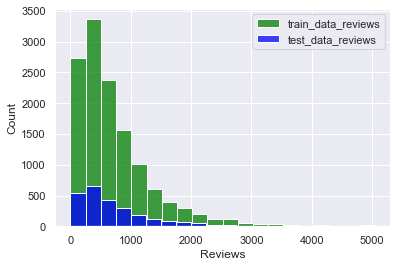

In [11]:
#checking the length of test and train data
# checking the length of the data
length_data_train=train_samples['Reviews'].str.len()
length_data_test=test_samples['Reviews'].str.len()
sns.histplot(length_data_train,bins=20,label='train_data_reviews',color='green')
sns.histplot(length_data_test,bins=20,label='test_data_reviews',color='blue')
plt.legend()
plt.show()

In [12]:
# Creating the checkpoint
train_data=train_samples.copy()
test_data=test_samples.copy()
train_data.head()

,Reviews,Ratings
0,"Casual Sushi\n\nFriendly service, nothing ritz...",1
1,I like by-the-weight frozen yogurt places! Eve...,1
2,When coupons from Restaurant.com where only $2...,0
3,"Like many others, came here on a Groupon for t...",1
4,"This place is mediocre , it's not bad but as a...",1


### 5. Preprocessing the data
 Preprocessing involves the following steps
 1. Removing punctuations,numbers and special characters.
 2. Converting all the words to lower alphabets
 3. Removing all the words whose length is less than 2 
 4. Text Normalization- The process in which the sentences are broken down to words for further processing

In [13]:
# Importing the libraries for preprocessing of text
import nltk
import re
from nltk.corpus import stopwords

In [14]:
#1. Removing punctuations,numbers and special characters
train_data['tidy_reviews']=train_data['Reviews'].str.replace("[^a-zA-Z#]"," ",regex=True)
test_data['tidy_reviews']=test_data['Reviews'].str.replace("[^a-zA-Z#]"," ",regex=True)
train_data=train_data[['Reviews','tidy_reviews','Ratings']]
train_data.head()

,Reviews,tidy_reviews,Ratings
0,"Casual Sushi\n\nFriendly service, nothing ritz...",Casual Sushi n nFriendly service nothing ritz...,1
1,I like by-the-weight frozen yogurt places! Eve...,I like by the weight frozen yogurt places Eve...,1
2,When coupons from Restaurant.com where only $2...,When coupons from Restaurant com where only ...,0
3,"Like many others, came here on a Groupon for t...",Like many others came here on a Groupon for t...,1
4,"This place is mediocre , it's not bad but as a...",This place is mediocre it s not bad but as a...,1


In [15]:
#2. Converting strings to lower case
train_data['tidy_reviews']=train_data['tidy_reviews'].str.lower()
test_data['tidy_reviews']=test_data['tidy_reviews'].str.lower()
train_data.head()

,Reviews,tidy_reviews,Ratings
0,"Casual Sushi\n\nFriendly service, nothing ritz...",casual sushi n nfriendly service nothing ritz...,1
1,I like by-the-weight frozen yogurt places! Eve...,i like by the weight frozen yogurt places eve...,1
2,When coupons from Restaurant.com where only $2...,when coupons from restaurant com where only ...,0
3,"Like many others, came here on a Groupon for t...",like many others came here on a groupon for t...,1
4,"This place is mediocre , it's not bad but as a...",this place is mediocre it s not bad but as a...,1


In [16]:
#3. Removing all the words whose length is less than 2 alphabets
train_data['tidy_reviews']=train_data['tidy_reviews'].apply(lambda x:" ".join([w for w in x.split() if len(w)>2]))
test_data['tidy_reviews']=test_data['tidy_reviews'].apply(lambda x:" ".join([w for w in x.split() if len(w)>2]))
train_data.head()

,Reviews,tidy_reviews,Ratings
0,"Casual Sushi\n\nFriendly service, nothing ritz...",casual sushi nfriendly service nothing ritzy v...,1
1,I like by-the-weight frozen yogurt places! Eve...,like the weight frozen yogurt places even thou...,1
2,When coupons from Restaurant.com where only $2...,when coupons from restaurant com where only fo...,0
3,"Like many others, came here on a Groupon for t...",like many others came here groupon for their t...,1
4,"This place is mediocre , it's not bad but as a...",this place mediocre not bad but italian girl l...,1


In [17]:
# 4. Text Normalization
tokenized_tweet=train_data['tidy_reviews'].apply(lambda x: x.split())
tokenized_tweet

0        [casual, sushi, nfriendly, service, nothing, r...
1        [like, the, weight, frozen, yogurt, places, ev...
2        [when, coupons, from, restaurant, com, where, ...
3        [like, many, others, came, here, groupon, for,...
4        [this, place, mediocre, not, bad, but, italian...
                               ...                        
12995    [been, here, many, times, since, moved, down, ...
12996    [land, terminal, and, have, get, terminal, nsh...
12997    [mexican, food, but, the, best, chili, relleno...
12998    [staying, the, quad, has, been, hands, down, t...
12999    [just, when, you, think, couldn, get, any, wor...
Name: tidy_reviews, Length: 13000, dtype: object

### 7. Lemmtization
Lemmatization is the process of using vocabulary and morphological analysis of words, normally aiming to remove unnecessary endings only and to return the base or dictionary form of a word, which is known as the lemma .

In [18]:
#Importing the library for lemmization
from nltk.stem import WordNetLemmatizer

In [19]:
# Creating an instance of the class WordNetLemmatizer
lemmatizer=nltk.wordnet.WordNetLemmatizer()
tokenized_tweet=tokenized_tweet.apply(lambda x:[lemmatizer.lemmatize(i) for i in x])

In [20]:
# stitching these tokens back together
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i]=' '.join(tokenized_tweet[i])
train_data['tidy_reviews']=tokenized_tweet
train_data.head()

,Reviews,tidy_reviews,Ratings
0,"Casual Sushi\n\nFriendly service, nothing ritz...",casual sushi nfriendly service nothing ritzy v...,1
1,I like by-the-weight frozen yogurt places! Eve...,like the weight frozen yogurt place even thoug...,1
2,When coupons from Restaurant.com where only $2...,when coupon from restaurant com where only for...,0
3,"Like many others, came here on a Groupon for t...",like many others came here groupon for their t...,1
4,"This place is mediocre , it's not bad but as a...",this place mediocre not bad but italian girl l...,1


### 6. Creating Word Clouds

In [21]:
from wordcloud import WordCloud

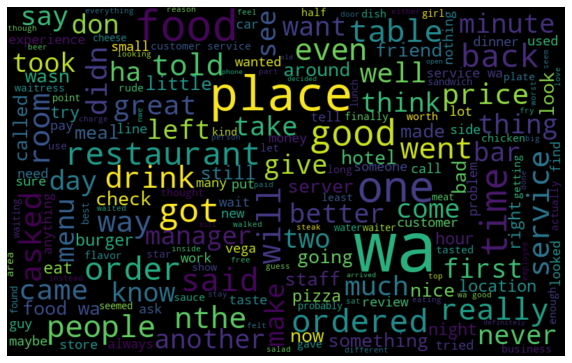

In [22]:
# visualizing the words used in negative reviews
negative_reviews=" ".join([text for text in train_data['tidy_reviews'][train_data['Ratings']==0]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=100).generate(negative_reviews)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

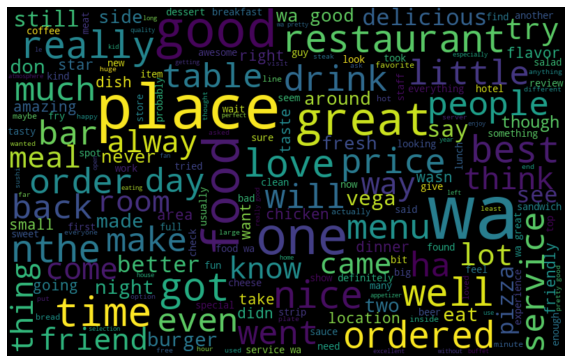

In [23]:
# visualizing the words used in positive reviews
positive_reviews=" ".join([text for text in train_data['tidy_reviews'][train_data['Ratings']==1]])
wordcloud=WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(positive_reviews)
plt.figure(figsize=(10,7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

### 7. Feature Extraction

For working of any machine learning model all the inputs has to be in feature form for the model to work. Feature Exracting involves claculating the features from the string of values using various vectorizers such as TF-IDF vectorizer or Count Vectorizer

In [24]:
# Importing the module from sklearn for TF-IDF features
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [25]:
xtrain=train_data['tidy_reviews']
ytrain=train_data['Ratings']
xtest=test_data['tidy_reviews']
ytest=test_data['Ratings']

In [31]:
# creating an instance of the class TFIDFVectorizer
vectorizer=TfidfVectorizer(min_df=3,max_features=2000,stop_words='english',analyzer='word')
xtrain_vectorized=vectorizer.fit_transform(xtrain)
test_vectorized=vectorizer.fit_transform(xtest)

### 8. Creating different models for calculating the accuracy 

### (1) Random Forest Classifier
A random forest is an ensemble classifier that estimates based on the combination of different decision trees. Effectively, it fits a number of decision tree classifiers on various subsamples of the dataset. Also, each tree in the forest built on a random best subset of features.

In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [32]:
rf=RandomForestClassifier(n_estimators=25)
rf.fit(xtrain_vectorized,ytrain)

RandomForestClassifier(n_estimators=25)

In [33]:
test_predict=rf.predict(test_vectorized)
accuracy_score(ytest,test_predict)

0.5772

In [34]:
confusion_matrix(ytest,test_predict)

array([[534, 461],
       [596, 909]], dtype=int64)

In [35]:
print(classification_report(ytest,test_predict))

              precision    recall  f1-score   support

           0       0.47      0.54      0.50       995
           1       0.66      0.60      0.63      1505

    accuracy                           0.58      2500
   macro avg       0.57      0.57      0.57      2500
weighted avg       0.59      0.58      0.58      2500



### (2) Logistic Regression
Logistic Regression measures the relationship between a output variable Y (categorical) and one or more independent variables, which are usually continuous (but not necessarily), by using probability scores as the predicted values of the dependent variables

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
# training the model
# creating an instance of the class LogisticRegression
lreg=LogisticRegression()
lreg.fit(xtrain_vectorized,ytrain)

LogisticRegression()

In [38]:
test_predict=lreg.predict(test_vectorized)
accuracy_score(ytest,test_predict)

0.5684

In [39]:
print(classification_report(ytest,test_predict))

              precision    recall  f1-score   support

           0       0.45      0.38      0.41       995
           1       0.63      0.69      0.66      1505

    accuracy                           0.57      2500
   macro avg       0.54      0.54      0.54      2500
weighted avg       0.56      0.57      0.56      2500



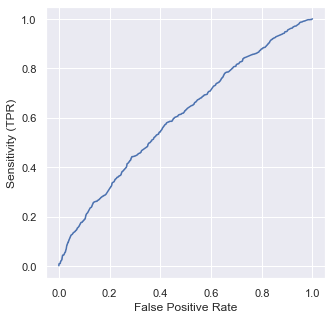

In [40]:
from sklearn.metrics import roc_curve
fpr,tpr,thresh=roc_curve(ytest,rf.predict_proba(test_vectorized)[:,1],pos_label=1)
random_probs=[0 for i in range(len(ytest))]
p_fpr,p_tpr,_=roc_curve(ytest,random_probs,pos_label=1)
plt.figure(figsize=(5,5))
sns.lineplot(x=fpr,y=tpr,);
plt.xlabel("False Positive Rate");
plt.ylabel("Sensitivity (TPR)");

### (3) XGBoost
XGBoost is the name of a machine learning method. It can help you to predict any kind of data if you have already predicted data before. We can classify any kind of data. It can be used for text classification too.

In [41]:
from xgboost import XGBClassifier

In [42]:
xgb_model=XGBClassifier(max_depth=10,n_estimators=500,use_label_encoder=False).fit(xtrain_vectorized,ytrain)

[13:08:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [43]:
test_predict=xgb_model.predict(test_vectorized)
accuracy_score(ytest,test_predict)

0.5512

### (4) Naive Bayes
Naive Bayes classifier (nBc) makes bold assumptions:
(1) The probability of occurence independent of the probability of occurence of another word.
(2) The probability of occurence of a word in a document, is independent of the location of that word within the document.

In [44]:
from sklearn.naive_bayes import MultinomialNB

In [45]:
classifier = MultinomialNB()
classifier.fit(xtrain_vectorized, ytrain)

MultinomialNB()

In [46]:
test_predit=classifier.predict(test_vectorized)
accuracy_score(ytest,test_predict)

0.5512

In [47]:
# Hyperparameter tuning the Naive Bayes Classifier
best_accuracy = 0.0
alpha_val = 0.0
for i in np.arange(0.05,1.5,0.1):
    temp_classifier = MultinomialNB(alpha=i)
    temp_classifier.fit(xtrain_vectorized, ytrain)
    temp_y_pred = temp_classifier.predict(test_vectorized)
    score = accuracy_score(ytest, temp_y_pred)
    print("Accuracy score for alpha={} is: {}%".format(round(i,1), round(score*100,2)))
    if score>best_accuracy:
        best_accuracy = score
        alpha_val = i
print('--------------------------------------------')
print('The best accuracy is {}% with alpha value as {}'.format(round(best_accuracy*100, 2), round(alpha_val,1)))

Accuracy score for alpha=0.0 is: 60.48%
Accuracy score for alpha=0.2 is: 60.44%
Accuracy score for alpha=0.3 is: 60.52%
Accuracy score for alpha=0.4 is: 60.48%
Accuracy score for alpha=0.5 is: 60.48%
Accuracy score for alpha=0.6 is: 60.44%
Accuracy score for alpha=0.7 is: 60.4%
Accuracy score for alpha=0.8 is: 60.44%
Accuracy score for alpha=0.9 is: 60.44%
Accuracy score for alpha=1.0 is: 60.36%
Accuracy score for alpha=1.1 is: 60.44%
Accuracy score for alpha=1.2 is: 60.32%
Accuracy score for alpha=1.3 is: 60.2%
Accuracy score for alpha=1.4 is: 60.12%
Accuracy score for alpha=1.5 is: 60.08%
--------------------------------------------
The best accuracy is 60.52% with alpha value as 0.3


### (5) Support Vector Machine(SVC)
In SVM the given labeled training data(supervised learning), the algorithm outputs an optimal hyperplane which categorizes the new examples.

In [48]:
from sklearn.svm import SVC

In [49]:
sv_model=SVC()
sv_model.fit(xtrain_vectorized,ytrain)

SVC()

In [50]:
test_predict=sv_model.predict(test_vectorized)
accuracy_score(ytest,test_predict)

0.5584

## EDA Augmentation

#### Data Augmentation is the practice of synthesizing new data from data at hand.Usually, the augmented data is similar to the data that is already available.

In [51]:
# Importing libraries for performing EDA Augmentation
import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc
from nlpaug.util import Action

In [52]:
# Another checkpoint
x_train=xtrain.copy()
y_train=ytrain.copy()

In [53]:
aug=naw.SynonymAug(aug_src='wordnet',aug_max=3)

In [54]:
sum(y_train==0)

5153

Introduce 2 new augmented sentences for each sentence in the training set with the label 0.
In each of these augmented sentences replace a maximum of 3 words by their synonyms.

In [55]:
augmented_sentences=[]
augmented_sentences_labels=[]
for i in x_train.index:
    if y_train[i]==0:
        temps=aug.augment(x_train[i],n=2)
        for sent in temps:
            augmented_sentences.append(sent)
            augmented_sentences_labels.append(0)

In [56]:
x_train=x_train.append(pd.Series(augmented_sentences),ignore_index=True)
y_train=y_train.append(pd.Series(augmented_sentences_labels),ignore_index=True)

In [57]:
# creating an instance of the class TFIDFVectorizer
vectorizer1=TfidfVectorizer(min_df=3,max_features=2000,stop_words='english',analyzer='word')
x_train_vectorized=vectorizer1.fit_transform(x_train)
#xvalid_vectorized=vectorizer.fit_transform(xvalid)
x_test_vectorized=vectorizer1.fit_transform(xtest)

In [58]:
rf1=RandomForestClassifier(n_estimators=25)
rf1.fit(x_train_vectorized,y_train)

RandomForestClassifier(n_estimators=25)

In [59]:
y_test_pred=rf1.predict(x_test_vectorized)
accuracy_score(ytest,y_test_pred)

0.556

In [60]:
from sklearn.metrics import roc_auc_score
roc_auc_score(ytest,rf1.predict_proba(x_test_vectorized)[:,1])

0.577732516402611

In [61]:
cf_matrix=confusion_matrix(ytest,y_test_pred)

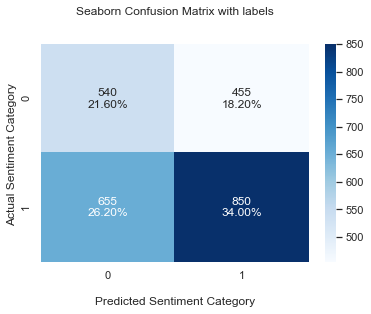

In [62]:
# There is a nicer and neater way of presenting the confusion matrix using heatmaps. 
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax=sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');
plt.show()
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['setosa','versicolor', 'virginica'])
#ax.yaxis.set_ticklabels(['setosa','versicolor', 'virginica'])

#### We can see we have the best accuracy with Naive Bayes model.
##### Random Forest Classifier-  57.7%
##### Logistic Regression-  56.8%
##### XGBoost-  55.1%
##### Naive Bayes-  60.5%
##### Support Vector Machine(SVM)-  55.8%
##### EDA Augmentation-  57.7%